## Parkinsons Telemonitoring Data Set 
https://archive.ics.uci.edu/ml/datasets/parkinsons+telemonitoring

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os, pickle
sys.path.insert(0, os.path.abspath('../..'))
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D
from keras import regularizers
from keras import backend as K
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import scipy
print ("Using TF:", tf.__version__)
print ("Using Keras:", keras.__version__)

# Import DASP
from dasp import DASP

#Import DeepLift
# Installation instructions: https://github.com/kundajelab/deeplift
import deeplift
from deeplift.layers import NonlinearMxtsMode
from deeplift.conversion import kerasapi_conversion as kc
from deeplift.util import compile_func

# Import Deep Explain (for Grad * Input, Integrated Gradients and Occlusion implementations)
# Installation instructions: https://github.com/marcoancona/DeepExplain
from deepexplain.tensorflow import DeepExplain

Using TensorFlow backend.


Using TF: 1.11.0
Using Keras: 2.2.4


In [2]:
# Build and train a network.

np.random.seed(15) # for riproducibility

SKIP_TRAIN = False
saved_model_file = '.model.h5'
saved_model_weights_file = '.model_weights.h5'

batch_size = 64
epochs = 1000 # using early stopping

# Load data from CSV
data = np.loadtxt(open("data/parkinsons_updrs.csv", "rb"), delimiter=",", skiprows=1).astype(np.float32)


np.random.shuffle(data)
data_y = data[:, 5]
data_x = data[:, [1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]]

scaler = MinMaxScaler(feature_range=(-1, 1))
print(scaler.fit(data_x))
data_x = scaler.transform(data_x)

assert np.isnan(data_x).any() == False
assert np.isnan(data_y).any() == False


print (data_x.shape)
x_test = data_x[:880]
y_test = data_y[:880]
x_train = data_x[880:]
y_train = data_y[880:]


print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print (y_train)
activation = 'relu'

if SKIP_TRAIN:
    model = load_model(saved_model_file)
else:
    model = Sequential()
    model.add(Dense(128, input_shape=(x_train.shape[1],), activation=activation, name='dense_1'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation=activation, name='dense_2'))
    model.add(Dropout(0.2))
    model.add(Dense(1, name='dense_3'))
    
    stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1)

    model.compile(loss=keras.losses.mean_squared_error,
                  optimizer=keras.optimizers.adam(),
                  metrics=['mae'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              callbacks=[stop],
              validation_data=(x_test, y_test))
    model.save(saved_model_file)
    model.save_weights(saved_model_weights_file)
print ("Done")
model.evaluate(x_test, y_test)



MinMaxScaler(copy=True, feature_range=(-1, 1))
(5875, 18)
x_train shape: (4995, 18)
4995 train samples
880 test samples
[17.699  36.747   7.8128 ... 15.419  18.199  40.196 ]
Epoch 00511: early stopping
Done
880/880 [==============================] - 0s 59us/step


[35.06389212174849, 4.430029526623812]

In [10]:
xs = x_test[0:100]
ys = y_test[0:100]

a_intgrad = np.zeros_like(xs)
a_res = np.zeros_like(xs)
a_rc = np.zeros_like(xs)
a_occlusion = np.zeros_like(xs)
a_dasp = np.zeros_like(xs)
a_exact = np.zeros_like(xs)

### Use Deep Shapley propagation to compute approximate Shapley Values.
Notice that this requires to convert our original model into a propababilistic one. We provide probabilistic layers for this.
Also, this will require O(c*n) evaluations of the probabilistic network, where n is the number of input features and c is the number of coalition sizes to be tested (ideally c = n)

In [11]:
# Init DASP
dasp = DASP(model)
# Get model description (optional)
dasp.model_summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 18)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 18)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_1 (ProbDenseInput)        (None, 128, 4)       2432        input_1[0][0]                    
                                                                 input_2[0][0]                    
          

In [13]:
# Run DASP with 18 (=n_input_features) coalition sizes
a_dasp = dasp.run(xs, 18)

### Use DeepExplain framework to compute Integrated Gradients and Occlusion

In [14]:
%time
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.output)
    target_tensor = fModel(input_tensor)
    
    a_intgrad = de.explain('intgrad', target_tensor, input_tensor, xs)
    a_occlusion = de.explain('occlusion', target_tensor, input_tensor, xs)
    intgrads = [(k, de.explain('intgrad', target_tensor, input_tensor, xs, steps=k)) for k in [1, 2, 4, 8, 16, 32, 64, 128]]
    print ("Done")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
DeepExplain: running "occlusion" explanation method (6)
Model with multiple inputs:  False
Input shape: (18,); window_shape (1,); step 1
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  Fals

### DeepLIFT

In [15]:
%%time
# Compute DeepLift attributions
revealcancel_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)

    
    
rescale_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.Rescale)

revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-1)
rescale_func = rescale_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-1)

a_rc = np.array([np.array(revealcancel_func(
                task_idx=0,
                input_data_list=[[x]],
                input_references_list=[[np.zeros_like(x)]],
                batch_size=100,
                progress_update=None)) for x in xs])

a_res = np.array([np.array(rescale_func(
                task_idx=0,
                input_data_list=[[x]],
                input_references_list=[[np.zeros_like(x)]],
                batch_size=100,
                progress_update=None)) for x in xs])
print (a_rc.shape)
a_rc = a_rc[:, 0, ...]
a_res = a_res[:, 0, ...]

nonlinear_mxts_mode is set to: RevealCancel
nonlinear_mxts_mode is set to: Rescale
(100, 1, 18)
CPU times: user 1min 7s, sys: 324 ms, total: 1min 7s
Wall time: 1min 7s


### Exact Shapley Values
Since there are only 18 input features, in this case it is possible to compute the exact Shapley Values in reasonable time.

In [17]:
%%time
from utils.exact_shapley import compute_shapley
a_exact = np.array([compute_shapley(xx, lambda x: model.predict(np.array(x)).sum(-1)) for xx in xs])

CPU times: user 2h 23min 42s, sys: 12min 7s, total: 2h 35min 49s
Wall time: 1h 33min 13s


In [36]:
attributions = [
    ('Integrated\nGradients',      a_intgrad.reshape(xs.shape)), 
    ('DL\n(Rescale)',              a_res.reshape(xs.shape)), 
    ('DL\n(RevCancel)',            a_rc.reshape(xs.shape)), 
    ('Occlusion',                  a_occlusion.reshape(xs.shape)), 
    ('DASP (Ours)',                a_dasp.reshape(xs.shape)), 
    ('GT',                         a_exact.reshape(xs.shape))
]

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:403: UserWarning: Warning: convertin

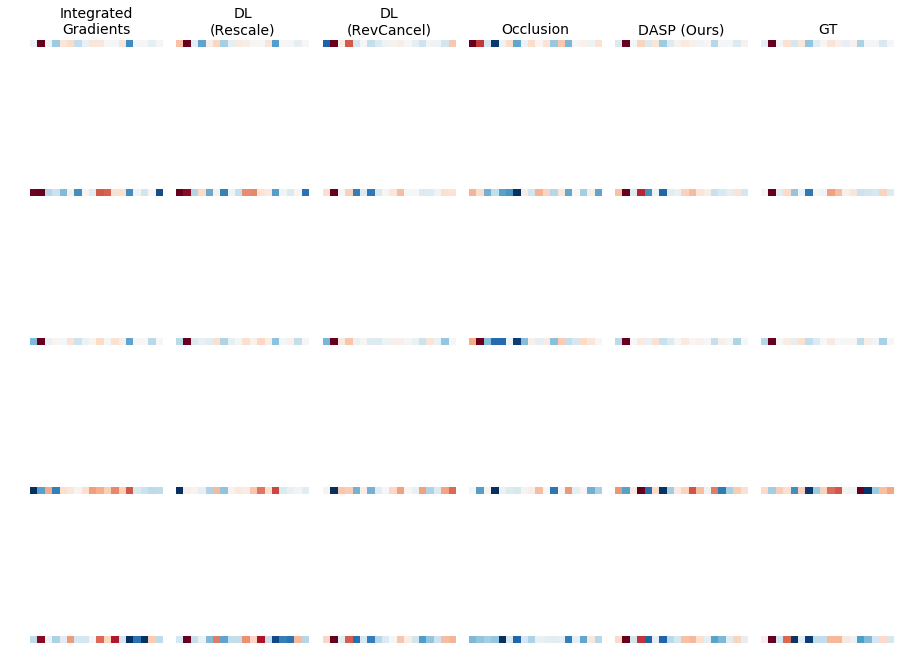

In [23]:
# Plot attributions
%matplotlib inline
from utils.utils import plot_attribution_maps

# Plot all
plot_attribution_maps("parkinson", 
                      np.ones_like(xs).reshape(-1, 1, 18), 
                      [x[1].reshape(-1, 1, 18) for x in attributions],
                      [x[0] for x in attributions],
                      percentile=100,
                      show_original=False,
                      dilation=2,
                      alpha=0.3,
                      idxs=range(5))

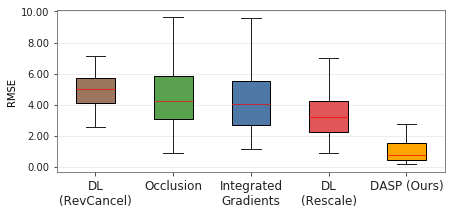

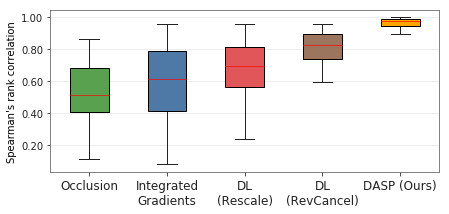

In [24]:
from utils.utils import plot_mse_comparison, plot_correlation_comparison

plot_mse_comparison('parkinson',
                    [x[1] for x in attributions],
                    [x[0] for x in attributions],
                    gt_idx=-1)
plot_correlation_comparison('parkinson',
                        [x[1] for x in attributions],
                        [x[0] for x in attributions],
                        gt_idx=-1)

## Comparison of feature importance assigned by Integrated Gradients and DASP
We use the plot from (Lundberg et al., 2017) to visualize how features are attributed different importance values over the 100 samples we are considering. In the following plot, each dot is an individual in the dataset. Notice, for example, how Integrated Gradients overestimates the impact (positive or negative) of *age*.

Exact


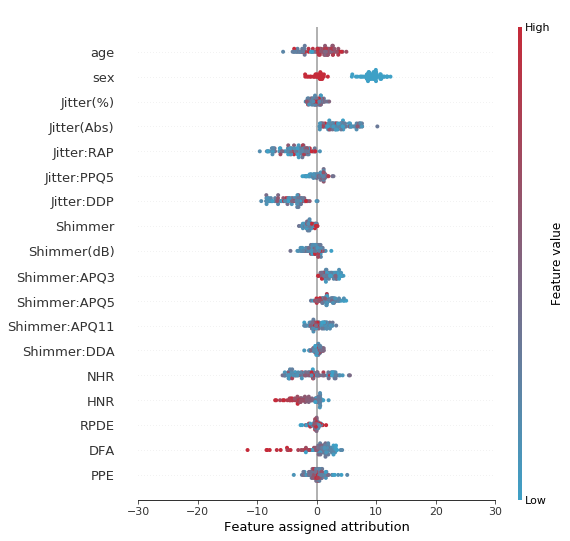

DASP


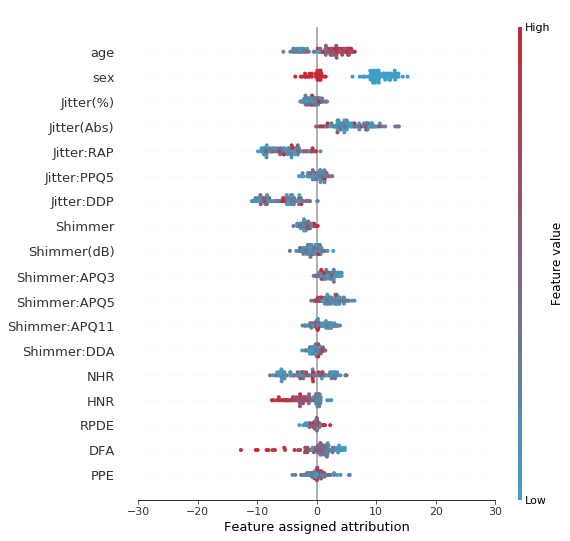

Integrated Gradients


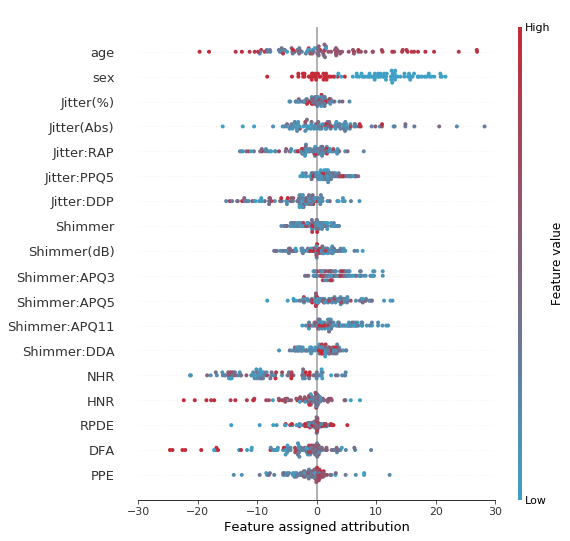

In [35]:
from utils.summary_plot import summary_plot
feat_names = [
"age","sex","Jitter(%)","Jitter(Abs)","Jitter:RAP","Jitter:PPQ5","Jitter:DDP","Shimmer","Shimmer(dB)","Shimmer:APQ3"
    ,"Shimmer:APQ5","Shimmer:APQ11","Shimmer:DDA","NHR","HNR","RPDE","DFA","PPE"]

summary_plot(a_exact[:, :], xs, feat_names, sort=False, limit=30, title="Exact")
summary_plot(a_dasp[:, 0, :], xs, feat_names, sort=False, limit=30, title="DASP")
summary_plot(a_intgrad, xs, feat_names, sort=False, limit=30, title='Integrated Gradients')